# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:8

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [227]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [228]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: #your answer here

во-первых, predict_proba просто напросто выводит вероятности, а не соотносит объект какому-то классу

во-вторых, DummyClassifier игнорирует входные данные, а “uniform”: generates predictions uniformly at random from the list of unique classes observed in y, i.e. each class has equal probability.

Так и получается, что равновероятно попадаем в 0 или в 1

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [229]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


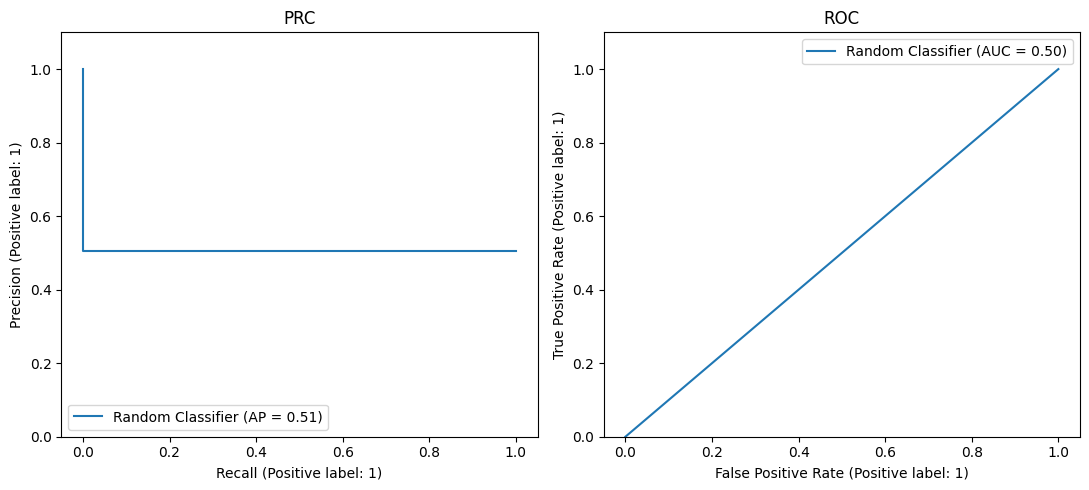

In [230]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [231]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [232]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# scoring = make_scorer()

In [233]:
#your code here
c_params = np.logspace(-2, 1, 30)

grid = GridSearchCV(LinearSVC(), param_grid={'C': c_params}, cv=3, scoring="average_precision")
grid = grid.fit(X_train, y_train)

/Users/eliseishinkarev/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/eliseishinkarev/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/eliseishinkarev/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/eliseishinkarev/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the v

In [234]:
print("Best C is: ", grid.best_params_['C'])

Best C is:  3.856620421163472


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [235]:
def normalize(decision_function):
    return (decision_function - decision_function.min()) / (decision_function.max() - decision_function.min())

GridSearchCV, LinearSVC metrics
AUC-PR: 0.83478
AUC-ROC: 0.84614


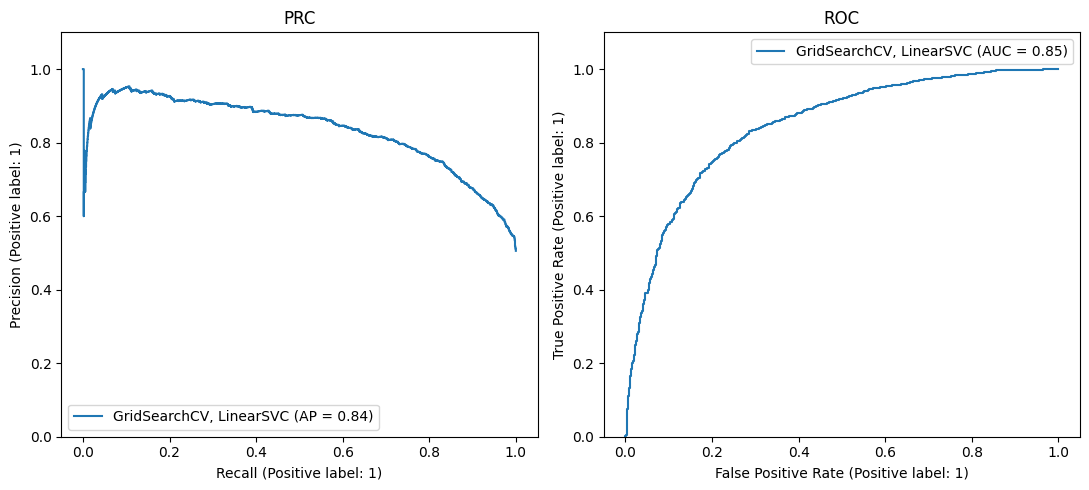

In [236]:
y_pred = normalize(grid.decision_function(X_test))

depict_pr_roc(y_test, y_pred, 'GridSearchCV, LinearSVC')

In [237]:
#your code here

# dataframe для сравнения
# методов классификации по метрикам
df_metrics_new = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_pred)
  # добавление очередной строки с характеристиками метода
df_metrics_new.loc['GridSearchCV, LinearSVC'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics_new

,AUC_PR,AUC_ROC,reg_const
"GridSearchCV, LinearSVC",0.834784,0.846142,0.0


Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [238]:
#your code here

print("AUC_PR diff: ", df_metrics_new['AUC_PR'][0] - df_metrics['AUC_PR'][0])
print("AUC_ROC diff: ", df_metrics_new['AUC_ROC'][0] - df_metrics['AUC_ROC'][0])

AUC_PR diff:  0.08195051721460389
AUC_ROC diff:  0.3461420155744448


/var/folders/7c/z64fqwds25nf5fy63rz44lf40000gn/T/ipykernel_54599/2445283216.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("AUC_PR diff: ", df_metrics_new['AUC_PR'][0] - df_metrics['AUC_PR'][0])
/var/folders/7c/z64fqwds25nf5fy63rz44lf40000gn/T/ipykernel_54599/2445283216.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("AUC_ROC diff: ", df_metrics_new['AUC_ROC'][0] - df_metrics['AUC_ROC'][0])


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [239]:
#your code here

c_params = np.logspace(-2, 1, 30)

log_reg = GridSearchCV(LogisticRegression(), param_grid={'C': c_params}, cv=3, scoring="average_precision")
log_reg = log_reg.fit(X_train, y_train)
print("Best C is: ", log_reg.best_params_['C'])

Best C is:  0.01


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000
GridSearchCV, LinearSVC metrics
AUC-PR: 0.83478
AUC-ROC: 0.84614
Logistic Regression metrics
AUC-PR: 0.82968
AUC-ROC: 0.84759


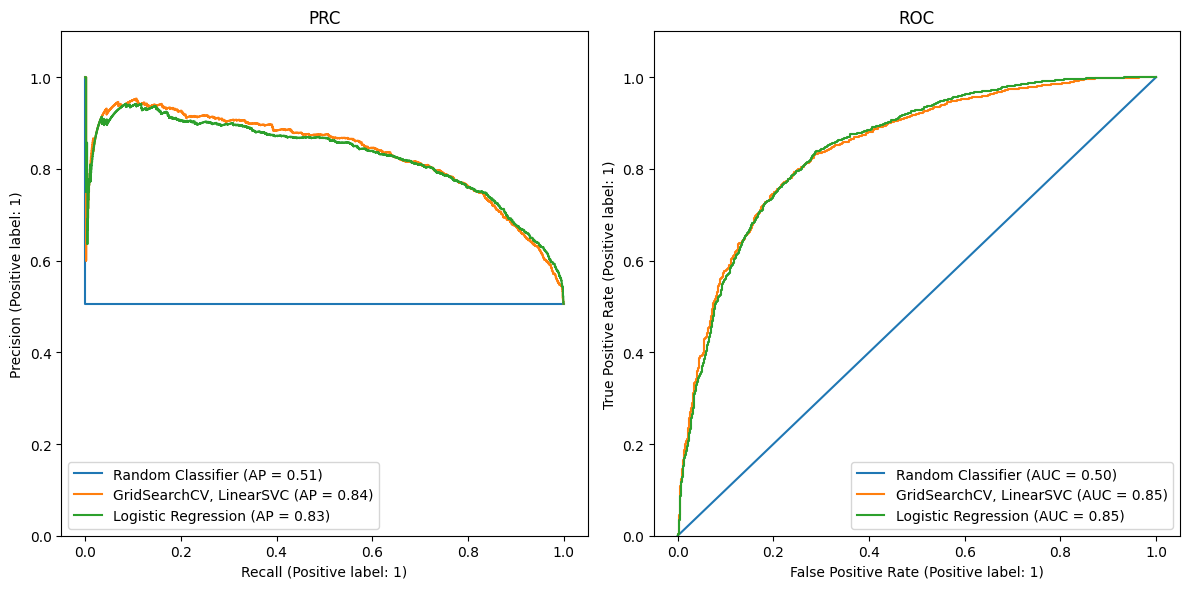

In [240]:
y_log_reg = log_reg.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

depict_pr_roc(y_test, y_random, 'Random Classifier', ax)
depict_pr_roc(y_test, y_pred, 'GridSearchCV, LinearSVC', ax)
depict_pr_roc(y_test, y_log_reg, 'Logistic Regression', ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** # your answer here

Поскольку данные рандомные, видимо, никакой зависимости особо нет, поэтому графики практически слились

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [241]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC

In [242]:
#your code here

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=200, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = SVC(kernel='linear')
model.fit(X, y)


SVC(kernel='linear')

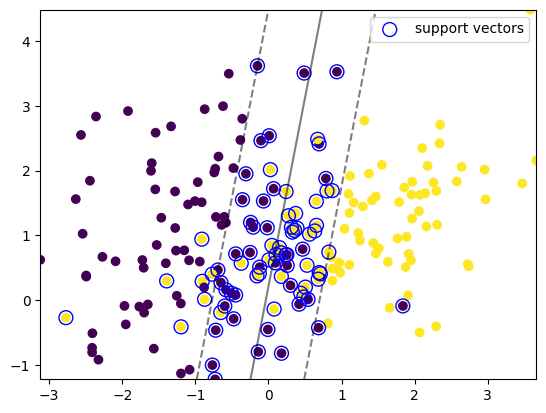

In [243]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y)

    # отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** #your answer here

опорные вектора - вектора, попавщие в зону отступа или выбившиеся из общей зоны

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [244]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

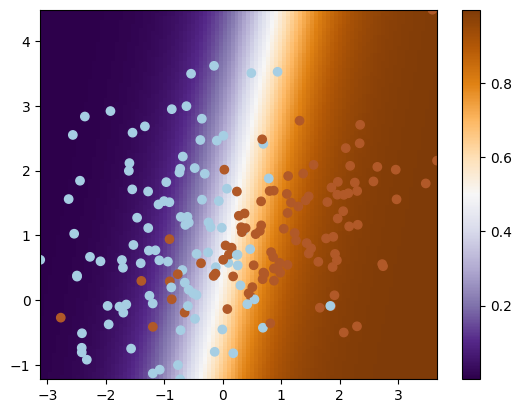

In [245]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** #your answer here

Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? 

Это буквально белая черта, граничная облась между двумя кластерами

Как это обосновать теоритечески? Мы нашли медиану, то есть порог распределения

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [246]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot([0, 1], [0, 1], label="diag", linestyle="-", color="red")
    plt.legend()
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [247]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

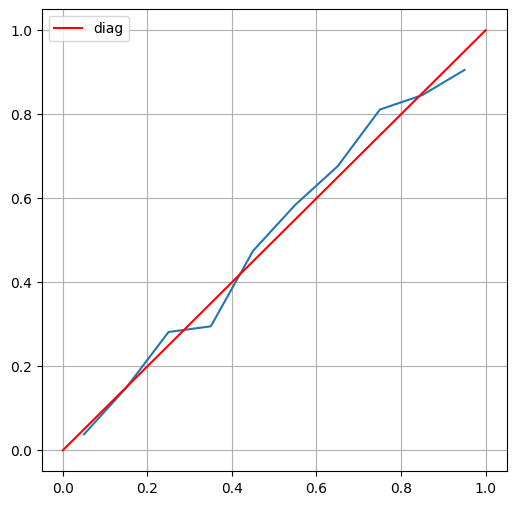

In [248]:
#your code here

c_params = np.logspace(-2, 1, 30)

log_reg = GridSearchCV(LogisticRegression(), param_grid={'C': c_params}, cv=3, scoring="average_precision")
log_reg = log_reg.fit(X_train, y_train)

y_log_reg = log_reg.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, y_log_reg)


/Users/eliseishinkarev/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/eliseishinkarev/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/eliseishinkarev/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/eliseishinkarev/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the v

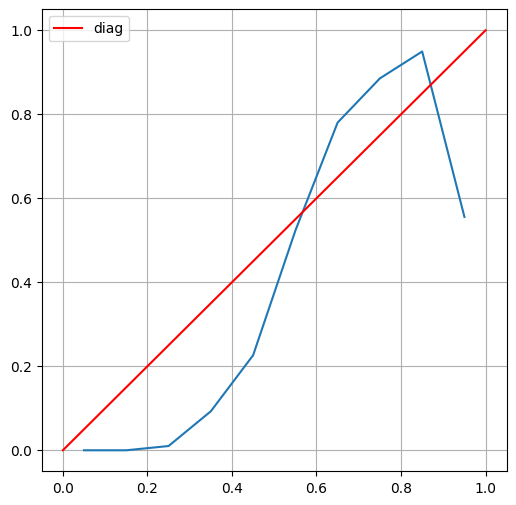

In [249]:
#your code here
c_params = np.logspace(-2, 1, 30)

grid = GridSearchCV(LinearSVC(), param_grid={'C': c_params}, cv=3, scoring="average_precision")
grid = grid.fit(X_train, y_train)

y_pred = normalize(grid.decision_function(X_test))

plot_calibration_curve(y_test, y_pred)

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** #your answer here

логистическая регрессия хорошо откалибрована, а вот SVM не очень

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

Text(0.5, 1.0, 'LogReg distribution')

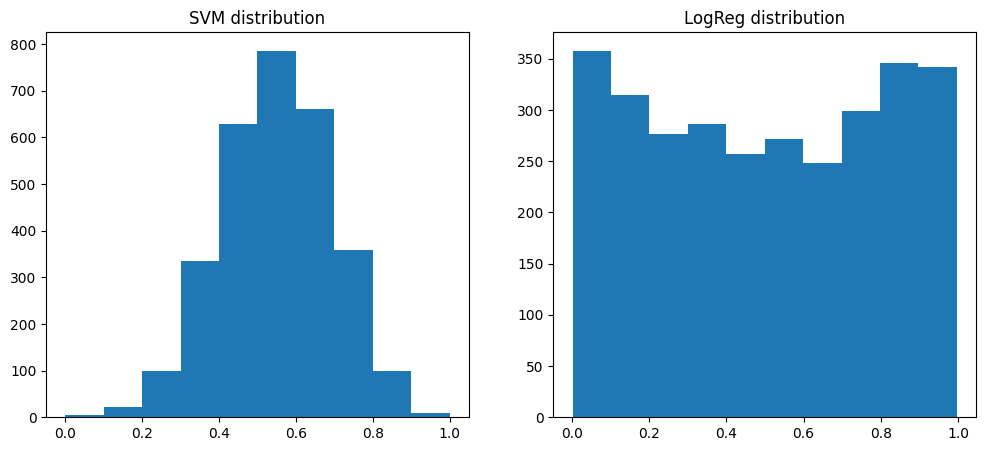

In [250]:
#your code here
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(y_pred)
ax[0].set_title('SVM distribution')
ax[1].hist(y_log_reg)
ax[1].set_title('LogReg distribution')

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** #your answer here

Метод опорных векторов как раз-таки имеет нормальное распределение, так как около медианы расположено много опорных векторов. А логрег оценивает все более-менее равномерно

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [251]:
from sklearn.calibration import CalibratedClassifierCV

/Users/eliseishinkarev/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/eliseishinkarev/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eliseishinkarev/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/eliseishinkarev/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eliseishinkarev/.pyenv/versions/3.11.5/lib/python3.

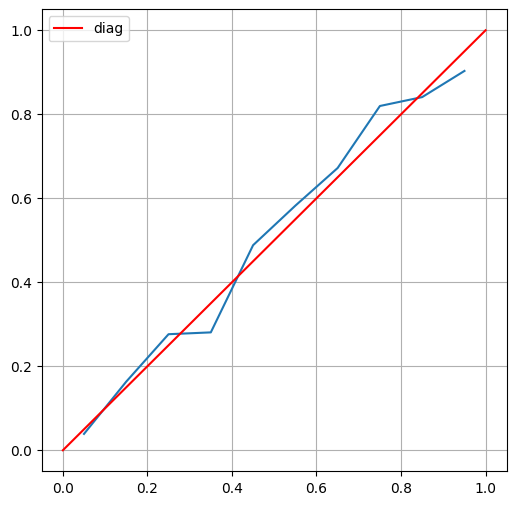

In [252]:
#your code here
c_params = np.logspace(-2, 1, 30)

grid = CalibratedClassifierCV(LinearSVC(), cv=3)
grid = grid.fit(X_train, y_train)

y_pred = grid.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, y_pred)

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** #your answer here

Явно улучшилось все


##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [253]:
from sklearn.isotonic import IsotonicRegression

In [254]:
# #your code here

# # c_params = np.logspace(-2, 1, 30)

# # isotonic_reg = GridSearchCV(IsotonicRegression(), param_grid={'C': c_params}, cv=3, scoring="average_precision")
# # X, y = make_classification(n_samples=10, n_features=1, random_state=42)
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# isotonic_reg = IsotonicRegression().fit(X_train, y_train)

# y_isotonic_reg = isotonic_reg.predict(X_test)

# plot_calibration_curve(y_test, y_isotonic_reg)


# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [255]:
df = pd.read_csv('archive-2/bike_buyers.csv')
#Заменим пропуски категориальных переменных
# df.fillna('undefined')
 
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

print(df.columns)

for col in ['Region', 'Commute Distance', 'Home Owner', 'Occupation', 'Education', 'Gender', 'Marital Status']:
    X[col] = X[col].fillna('undefined')

#Разделим на категориальные признаки и числовые
X_numerical = X.loc[:, ['Income', 'Age', 'Cars', 'Children']]
X_categorical = X.loc[:, ['Region', 'Commute Distance', 'Home Owner', 'Occupation', 'Education', 'Gender', 'Marital Status']]

# df['Region', 'Commute Distance', 'Home Owner', 'Occupation', 'Education', 'Gender', 'Marital Status'].fillna('undefined')

Index(['ID', 'Marital Status', 'Gender', 'Income', 'Children', 'Education',
       'Occupation', 'Home Owner', 'Cars', 'Commute Distance', 'Region', 'Age',
       'Purchased Bike'],
      dtype='object')


В начале поработаем только с категориальными признаками

In [256]:
X.isna().sum()

ID                  0
Marital Status      0
Gender              0
Income              6
Children            8
Education           0
Occupation          0
Home Owner          0
Cars                9
Commute Distance    0
Region              0
Age                 8
dtype: int64

In [257]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [258]:
from sklearn.preprocessing import OrdinalEncoder
import time
from sklearn.preprocessing import OneHotEncoder

In [259]:
start_time = time.time()
ord_enc = OrdinalEncoder()
X_train_encoded = ord_enc.fit_transform(X_train)
X_test_encoded = ord_enc.transform(X_test)

In [260]:
model = LogisticRegression().fit(X_train_encoded, y_train)
y_pred = model.predict_proba(X_test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print("Total time: ", time.time() - start_time)

AUC-PR: 0.57894
Total time:  0.020849227905273438


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [261]:
start_time = time.time()
one_hot_enc = OneHotEncoder()
X_train_hot_encoded = one_hot_enc.fit_transform(X_train)
X_test_hot_encoded = one_hot_enc.transform(X_test)

In [262]:
model = LogisticRegression().fit(X_train_hot_encoded, y_train)
y_pred = model.predict_proba(X_test_hot_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print("Total time: ", time.time() - start_time)

AUC-PR: 0.66186
Total time:  0.02710890769958496


Точность ван хот энкодера выше, чем ординал энкодера, что в целом логично. Однако точность хуже, чем та, что мы в самом начале посчитали. Скорее всего от того, что мы никак не обрабатываем числовые признаки

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [263]:
from sklearn.base import BaseEstimator, TransformerMixin

In [264]:
class MeanTargetTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = []
        if columns is not None:
            self.columns = columns
        self.column_mean_values = {}

    def fit(self, X, y=None):
        self.y = y
        self.X = X
        for column in self.columns:
            concated_grouped_train = pd.concat([X_train[column], y_train], axis=1).groupby(column)
            self.column_mean_values[column] = concated_grouped_train[y.name].mean()        
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for column, column_mean in self.column_mean_values.items():
            X_copy[column] = X[column].map(column_mean).fillna(self.y.mean())
        return X_copy

In [265]:
start_time = time.time()
mean_target_transformer = MeanTargetTransformer(['Region', 'Commute Distance', 'Home Owner', 'Occupation', 'Education', 'Gender', 'Marital Status'])
X_train_mean_target = (mean_target_transformer.fit(X_train, y_train)).transform(X_train)
X_test_mean_target = mean_target_transformer.transform(X_test)

In [266]:
model = LogisticRegression().fit(X_train_mean_target, y_train)
y_pred = model.predict_proba(X_test_mean_target)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print("Total time: ", time.time() - start_time)

AUC-PR: 0.65269
Total time:  0.014076948165893555


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [267]:
class MeanTargetTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = []
        if columns is not None:
            self.columns = columns
        self.column_mean_values = {}

    def fit(self, X, y=None):
        self.y = y
        self.X = X
        for column in self.columns:
            concated_grouped_train = pd.concat([X_train[column], y_train], axis=1).groupby(column)
            self.column_mean_values[column] = concated_grouped_train[y.name].mean()        
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for column, column_mean in self.column_mean_values.items():
            X_copy[column] = X[column].map(column_mean).fillna(self.y.mean())
        return X_copy

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [268]:
class MeanTargetTransformerNoise(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, noise=False):
        self.columns = []
        self.noise = noise
        if columns is not None:
            self.columns = columns
        self.column_mean_values = {}

    def fit(self, X, y=None):
        self.y = y
        self.X = X
        eps = 0
        for column in self.columns:
            if self.noise:
                eps = np.random.normal(0, 0.1)
            concated_grouped_train = pd.concat([X_train[column], y_train], axis=1).groupby(column)
            # concated_grouped_train[y.name] = concated_grouped_train[y.name].apply(lambda x: x.assign(x + eps))
            self.column_mean_values[column] = (concated_grouped_train[y.name]).mean() + eps
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for column, column_mean in self.column_mean_values.items():
            X_copy[column] = X[column].map(column_mean).fillna(self.y.mean())
        return X_copy

In [269]:
start_time = time.time()
mean_target_transformer_noise = MeanTargetTransformerNoise(['Region', 'Commute Distance', 'Home Owner', 'Occupation', 'Education', 'Gender', 'Marital Status'], True)
X_train_with_noise = (mean_target_transformer_noise.fit(X_train, y_train)).transform(X_train)
X_test_with_noise = mean_target_transformer_noise.transform(X_test)

In [270]:
model = LogisticRegression().fit(X_train_with_noise, y_train)
y_pred = model.predict_proba(X_test_with_noise)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print("Total time: ", time.time() - start_time)

AUC-PR: 0.65269
Total time:  1.67429518699646


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** #your answer here

Видимо, шум не помогает особо. Предположу, что я взял либо слишком малое значение шума, либо рандомное отклонение в значении нас также рандомно отведет от значения AUC-PR

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [187]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [271]:
class MeanTargetTransformerSmooth(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, noise=False, C=0):
        self.columns = []
        self.C = C
        self.noise = noise
        if columns is not None:
            self.columns = columns
        self.column_mean_values = {}

    def fit(self, X, y=None):
        self.y = y
        self.X = X
        global_mean = y.mean()
        for column in self.columns:
            concated_grouped_train = pd.concat([X_train[column], y_train], axis=1).groupby(column)
            self.column_mean_values[column] = (self.C * global_mean + concated_grouped_train[y.name].sum()) / (len(X) + self.C) 
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for column, column_mean in self.column_mean_values.items():
            X_copy[column] = X[column].map(column_mean).fillna(self.y.mean())
        return X_copy

In [272]:
c_params = np.logspace(-2, 3, 20)
auc_lst = []
time_lst = []

for c in c_params:
    start_time = time.time()
    mean_target_transformer_smooth = MeanTargetTransformerSmooth(['Region', 'Commute Distance', 'Home Owner', 'Occupation', 'Education', 'Gender', 'Marital Status'], True, c)
    X_train_smooth = (mean_target_transformer_smooth.fit(X_train, y_train)).transform(X_train)
    X_test_smooth = mean_target_transformer_smooth.transform(X_test)
    
    model = LogisticRegression().fit(X_train_smooth, y_train)
    y_pred = model.predict_proba(X_test_smooth)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_lst.append(auc(recall, precision))
    time_lst.append(time.time() - start_time)
    print('Current C: %.5f' % c)
    print('AUC-PR: %.5f' % auc_lst[-1])
    print("Total time: ", time_lst[-1])

Current C: 0.01000
AUC-PR: 0.65348
Total time:  0.017350196838378906
Current C: 0.01833
AUC-PR: 0.65348
Total time:  0.011998891830444336
Current C: 0.03360
AUC-PR: 0.65348
Total time:  0.009833812713623047
Current C: 0.06158
AUC-PR: 0.65348
Total time:  0.008938074111938477
Current C: 0.11288
AUC-PR: 0.65348
Total time:  0.008759021759033203
Current C: 0.20691
AUC-PR: 0.65348
Total time:  0.008413076400756836
Current C: 0.37927
AUC-PR: 0.65348
Total time:  0.0072479248046875
Current C: 0.69519
AUC-PR: 0.65348
Total time:  0.007580995559692383
Current C: 1.27427
AUC-PR: 0.65352
Total time:  0.008734941482543945
Current C: 2.33572
AUC-PR: 0.65369
Total time:  0.007046937942504883
Current C: 4.28133
AUC-PR: 0.65369
Total time:  0.006942272186279297
Current C: 7.84760
AUC-PR: 0.65361
Total time:  0.007020235061645508
Current C: 14.38450
AUC-PR: 0.65367
Total time:  0.007004261016845703
Current C: 26.36651
AUC-PR: 0.65369
Total time:  0.007021665573120117
Current C: 48.32930
AUC-PR: 0.6534

In [273]:
best_ind = np.argmin(auc_lst)

print("For best auc = {}, C is {}, time -> {}".format(auc_lst[best_ind], c_params[best_ind], time_lst[best_ind]))

For best auc = 0.6532744518030791, C is 162.3776739188721, time -> 0.00783991813659668


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [274]:
for num in ['Income', 'Age', 'Cars', 'Children']:
    col_mean = X_numerical[num].mean()
    X_numerical[num] = X_numerical[num].fillna(col_mean)
X_numerical.isna().sum()

Income      0
Age         0
Cars        0
Children    0
dtype: int64

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [275]:
X_numerical.nunique()

Income      17
Age         54
Cars         6
Children     7
dtype: int64

In [276]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.25, random_state=777, stratify=y)

In [278]:
c_params = np.logspace(-2, 3, 20)
auc_lst = []
time_lst = []

for param in c_params:
    c = param
    start_time = time.time()
    mean_target_transformer_smooth = MeanTargetTransformerSmooth(['Income', 'Age', 'Cars', 'Children'], True, c)
    X_train_smooth = (mean_target_transformer_smooth.fit(X_train, y_train)).transform(X_train)
    X_test_smooth = mean_target_transformer_smooth.transform(X_test)
    
    model = LogisticRegression().fit(X_train_smooth, y_train)
    y_pred = model.predict_proba(X_test_smooth)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_lst.append(auc(recall, precision))
    time_lst.append(time.time() - start_time)
    print('Current C: %.5f' % c)
    print('AUC-PR: %.5f' % auc_lst[-1])
    print("Total time: ", time_lst[-1])

Current C: 0.01000
AUC-PR: 0.55965
Total time:  0.0195920467376709
Current C: 0.01833
AUC-PR: 0.55965
Total time:  0.00712275505065918
Current C: 0.03360
AUC-PR: 0.55965
Total time:  0.008209943771362305
Current C: 0.06158
AUC-PR: 0.55965
Total time:  0.005588054656982422
Current C: 0.11288
AUC-PR: 0.55965
Total time:  0.005228757858276367
Current C: 0.20691
AUC-PR: 0.55965
Total time:  0.005265235900878906
Current C: 0.37927
AUC-PR: 0.55965
Total time:  0.005063056945800781
Current C: 0.69519
AUC-PR: 0.55965
Total time:  0.006139039993286133
Current C: 1.27427
AUC-PR: 0.55965
Total time:  0.004687070846557617
Current C: 2.33572
AUC-PR: 0.55965
Total time:  0.00518798828125
Current C: 4.28133
AUC-PR: 0.55961
Total time:  0.004549741744995117
Current C: 7.84760
AUC-PR: 0.55946
Total time:  0.0042150020599365234
Current C: 14.38450
AUC-PR: 0.55942
Total time:  0.004307985305786133
Current C: 26.36651
AUC-PR: 0.55933
Total time:  0.004373073577880859
Current C: 48.32930
AUC-PR: 0.55925
To

In [279]:
best_ind = np.argmin(auc_lst)

print("For best auc = {}, C is {}, time -> {}".format(auc_lst[best_ind], c_params[best_ind], time_lst[best_ind]))

For best auc = 0.5519446992178716, C is 1000.0, time -> 0.0044248104095458984


In [280]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [281]:
c_params = np.logspace(-2, 3, 20)
auc_lst = []
time_lst = []

for c in c_params:
    start_time = time.time()
    mean_target_transformer_smooth = MeanTargetTransformerSmooth(['Region', 'Commute Distance', 'Home Owner', 'Occupation', 'Education', 'Gender', 'Marital Status', 'Income', 'Age', 'Cars', 'Children'], True, c)
    X_train_smooth = (mean_target_transformer_smooth.fit(X_train, y_train)).transform(X_train)
    X_test_smooth = mean_target_transformer_smooth.transform(X_test)
    model = LogisticRegression().fit(X_train_smooth, y_train)
    y_pred = model.predict_proba(X_test_smooth)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_lst.append(auc(recall, precision))
    time_lst.append(time.time() - start_time)
    print('Current C: %.5f' % c)
    print('AUC-PR: %.5f' % auc_lst[-1])
    print("Total time: ", time_lst[-1])

Current C: 0.01000
AUC-PR: 0.47047
Total time:  0.023200035095214844
Current C: 0.01833
AUC-PR: 0.47047
Total time:  0.01290583610534668
Current C: 0.03360
AUC-PR: 0.47047
Total time:  0.011410951614379883
Current C: 0.06158
AUC-PR: 0.47047
Total time:  0.010518074035644531
Current C: 0.11288
AUC-PR: 0.47047
Total time:  0.010805845260620117
Current C: 0.20691
AUC-PR: 0.47047
Total time:  0.014162063598632812
Current C: 0.37927
AUC-PR: 0.47047
Total time:  0.011257171630859375
Current C: 0.69519
AUC-PR: 0.47047
Total time:  0.009194135665893555
Current C: 1.27427
AUC-PR: 0.47047
Total time:  0.00873708724975586
Current C: 2.33572
AUC-PR: 0.47047
Total time:  0.008533000946044922
Current C: 4.28133
AUC-PR: 0.47047
Total time:  0.00884699821472168
Current C: 7.84760
AUC-PR: 0.47047
Total time:  0.008740901947021484
Current C: 14.38450
AUC-PR: 0.47047
Total time:  0.008786201477050781
Current C: 26.36651
AUC-PR: 0.47047
Total time:  0.008424043655395508
Current C: 48.32930
AUC-PR: 0.47047

In [282]:
best_ind = np.argmin(auc_lst)

print("For best auc = {}, C is {}, time -> {}".format(auc_lst[best_ind], c_params[best_ind], time_lst[best_ind]))

For best auc = 0.4704697047689722, C is 0.01, time -> 0.023200035095214844


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ #your answer here

ну счетчики выбивают часто качество лучше, однако для этого очередной перебор гиперпараметров устраиваем

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [283]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-22 23:15:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «adult.data.3»

adult.data.3            [        <=>         ]   3,79M  1,97MB/s    за 1,9s    

2023-11-22 23:15:57 (1,97 MB/s) - «adult.data.3» сохранён [3974305]



In [284]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
16755,38,?,181705,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,24,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [285]:
#your code here
y = df['income']
df.drop('income', axis=1, inplace=True)
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)
categorical = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
numerical = ["age", "capital-gain", "capital-loss", "hours-per-week"]

In [286]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [287]:
one_hot_enc = OneHotEncoder()
X_train_hot_encoded = one_hot_enc.fit_transform(X_train[categorical])
print(X_train_hot_encoded.shape, X_train[categorical].shape)

(24420, 102) (24420, 8)


In [288]:
print("Count of new features: {}".format(X_train_hot_encoded.shape[1] - X_train[categorical].shape[1]))

Count of new features: 94


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [289]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numerical)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
]
)

In [290]:
#your code here
# X_train_hot_encoded = one_hot_enc.fit_transform(X_train)
# X_test_hot_encoded = one_hot_enc.transform(X_test[categorical])
# model = LogisticRegression(max_iter=1000)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.76638


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [65]:
#your code here

Изменилось ли качество? Как?

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [66]:
#your code here

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [67]:
#your code here

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [68]:
#your code here

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [69]:
#your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [70]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [71]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-22 21:57:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.


HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «bank-additional.zip.3»

bank-additional.zip     [   <=>              ] 434,15K   466KB/s    за 0,9s    

2023-11-22 21:57:09 (466 KB/s) - «bank-additional.zip.3» сохранён [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [111]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [112]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [113]:
# your code here
from sklearn.model_selection import KFold

kf = KFold(5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [114]:
# your code here
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'previous', 'poutcome']
numerical = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numerical)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
]
)

In [115]:
for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index].values, y.iloc[test_index].values

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    print("Fold number: {}, AUC-PR is {}".format(fold_index + 1, auc(recall, precision)))


Fold number: 1, AUC-PR is 0.4793384138850682
Fold number: 2, AUC-PR is 0.43779175104025536
Fold number: 3, AUC-PR is 0.4491266070697616
Fold number: 4, AUC-PR is 0.4548637189671442
Fold number: 5, AUC-PR is 0.4262676896612285


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [116]:
call_incomes = []
call_payments = []

for fold_index, (train_index, test_index) in enumerate(kf.split(X)):

    client_payment = 10

    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index].values, y.iloc[test_index].values
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    call_income = (y_pred & y_test).sum()
    call_incomes.append(call_income * client_payment)

    call_payment = y_pred.sum()
    call_payments.append(call_payment)

print("Средняя выручка равна {}; \n Средняя прибыль равна {}; \n Средние расходы {}; \n Всего расходов {}".format(np.mean(call_incomes), np.mean(call_incomes) - np.mean(call_payments), np.mean(call_payments), np.sum(call_payments)))
print("Стандартное отклонение по выручке {}, по расходам {}".format(np.std(call_incomes), np.std(call_payments)))


Средняя выручка равна 2088.0; 
 Средняя прибыль равна 1770.2; 
 Средние расходы 317.8; 
 Всего расходов 1589
Стандартное отклонение по выручке 132.12115651930995, по расходам 7.730459236035076


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [117]:
call_incomes = []
call_payments = []

for fold_index, (train_index, test_index) in enumerate(kf.split(X)):

    client_payment = np.random.uniform(0, 20)

    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index].values, y.iloc[test_index].values
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    call_income = (y_pred & y_test).sum()
    call_incomes.append(call_income * client_payment)

    call_payment = y_pred.sum()
    call_payments.append(call_payment)

print("Средняя выручка равна {}; \n Средняя прибыль равна {}; \n Средние расходы {}; \n Всего расходов {}".format(np.mean(call_incomes), np.mean(call_incomes) - np.mean(call_payments), np.mean(call_payments), np.sum(call_payments)))
print("Стандартное отклонение по выручке {}, по расходам {}".format(np.std(call_incomes), np.std(call_payments)))


Средняя выручка равна 1471.8701676413878; 
 Средняя прибыль равна 1154.0701676413878; 
 Средние расходы 317.8; 
 Всего расходов 1589
Стандартное отклонение по выручке 988.2435524626146, по расходам 7.730459236035076


С каждым перезапуском значение стандартного отклонения меняется. Оно в любом случае больше предыдущих результатов, однако теперь совершенно иначе влияет на прибыль


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [118]:
c_params = np.logspace(-1, 1.5, 30)
mean_income_lst = []
mean_std_lst = []
# call_incomes = []
# call_payments = []

for c in c_params:
    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LogisticRegression(max_iter=1000, C=c))
    ]
    )
    call_incomes = []
    call_payments = []

    for fold_index, (train_index, test_index) in enumerate(kf.split(X)):

        client_payment = np.random.uniform(0, 20)

        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index].values, y.iloc[test_index].values
        model = pipeline.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        call_income = (y_pred & y_test).sum()
        call_incomes.append(call_income * client_payment)

        call_payment = y_pred.sum()
        call_payments.append(call_payment)

    mean_income_lst.append(np.mean(call_incomes))
    mean_std_lst.append(np.std(call_incomes))

In [119]:
max_ind = np.argmax(mean_income_lst)
print("Best income is {}, with C = {}".format(mean_income_lst[max_ind], c_params[max_ind]))

Best income is 3087.1126900733243, with C = 0.5968456995122311


Text(0, 0.5, 'Income')

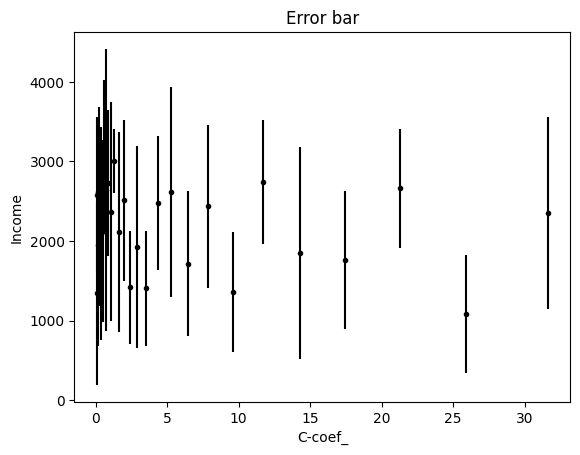

In [120]:
# plt.errorbar(cs, incomes, yerr=var_incomes, fmt='.k')
plt.errorbar(c_params, mean_income_lst, yerr=mean_std_lst, fmt='.k')
plt.title('Error bar')
plt.xlabel('C-coef_')
plt.ylabel('Income')


Скорее всего я попал в какую-то везучую точку, но есть даже коэффициенты с высокой выручкой и несильно большой дисперсией (или такой, которая обгоняет предыдущие запуски). Так что как будто бы выигрыш достигнут

P.S. Изображение после пергенеривания, где как раз-таки нет тех самых "везучих" точек, которые выше 3000 и с маленькой дисперсией

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [121]:
several_times = range(5)

for time in several_times:
    c_params = np.logspace(-2, 2, 30)
    mean_income_lst = []
    mean_std_lst = []
    # call_incomes = []
    # call_payments = []

    for c in c_params:
        pipeline = Pipeline(steps=[
            ('ohe_and_scaling', column_transformer),
            ('regression', LogisticRegression(max_iter=1000, C=c))
        ]
        )
        call_incomes = []
        call_payments = []

        for fold_index, (train_index, test_index) in enumerate(kf.split(X)):

            client_payment = np.random.uniform(0, 20)

            X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index].values, y.iloc[test_index].values
            model = pipeline.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            call_income = (y_pred & y_test).sum()
            call_incomes.append(call_income * client_payment)

            call_payment = y_pred.sum()
            call_payments.append(call_payment)

        mean_income_lst.append(np.mean(call_incomes))
        mean_std_lst.append(np.std(call_incomes))
    
    max_ind = np.argmax(mean_income_lst)
    print("Best income is {}, with C = {} and attempt number {}".format(mean_income_lst[max_ind], c_params[max_ind], time))

Best income is 3072.725087864146, with C = 0.01 and attempt number 0
Best income is 3267.773730300344, with C = 28.072162039411758 and attempt number 1
Best income is 2987.8832114438037, with C = 52.98316906283707 and attempt number 2
Best income is 2935.1846268191152, with C = 38.56620421163472 and attempt number 3
Best income is 3407.267403777749, with C = 38.56620421163472 and attempt number 4


один и тот же коэффициент не находится, а еще закономерности как будто бы нет. вообще

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here

Ну выручка от прихода клиента заманчивее затраты на звонок, поэтому я бы предпочел recall


> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [122]:
#your code here
mean_income_lst = []
mean_std_lst = []

c_params = np.linspace(0, 1, 100)

for param in c_params:
    call_incomes = []

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LogisticRegression(max_iter=1000, C=c))
    ]
    )

    for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
        client_payment = np.random.uniform(0, 20)

        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index].values, y.iloc[test_index].values
        model = pipeline.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        # print(c_params)
        # print(param, y_pred)
        # y_pred = y_pred[y_pred > c]
        # print(np.where(y_pred > param, 1, 0))
        y_pred = np.where(y_pred > param, 1, 0)
        
        call_income = (y_pred & y_test).sum()
        call_incomes.append(call_income * client_payment - y_pred.sum())
        # print(y_pred.sum(), call_incomes[-1])
    
    mean_income_lst.append(np.mean(call_incomes))
    mean_std_lst.append(np.std(call_incomes))



In [123]:
max_ind = np.argmax(mean_income_lst)
print("Best income is {}, with C = {}".format(mean_income_lst[max_ind], c_params[max_ind]))

Best income is 6745.849749116028, with C = 0.07070707070707072


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




Text(0, 0.5, 'Income')

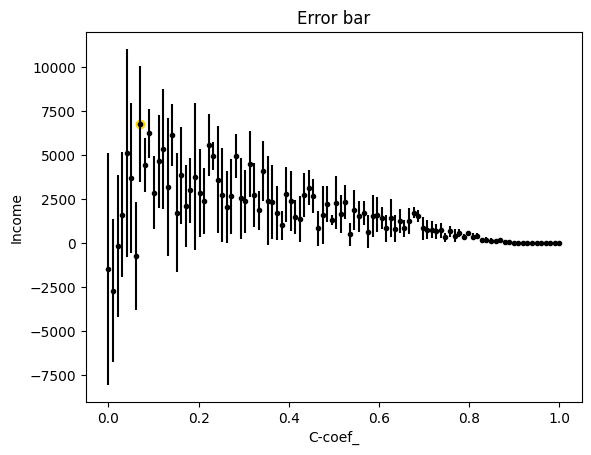

In [124]:
#your code here
plt.errorbar(c_params, mean_income_lst, yerr=mean_std_lst, fmt='.k')
plt.scatter(c_params[max_ind], mean_income_lst[max_ind], color='gold')
plt.title('Error bar')
plt.xlabel('C-coef_')
plt.ylabel('Income')

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ #your answer here

ну оптимальные ответы как будто бы при С от 0.15 до 0.25 примерно. Почему так, не знаю. Вероятно, мы в какой-то момент обзваниваем всех, что не очень выгодно, а после какого-то порога в 0.4 примерно, все больший заработок мы гарантированно получаем, однако от достаточного малого количества человек

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [125]:
#your code here
# mean_income_lst = []
# mean_std_lst = []
precisions = []
recalls = []

param = c_params[max_ind]

for i in range(1):
    # call_incomes = []
    # call_payments = []

    for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
        client_payment = np.random.uniform(0, 20)

        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index].values, y.iloc[test_index].values
        model = pipeline.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        y_pred = np.where(y_pred > param, 1, 0)
        
        # call_income = (y_pred & y_test).sum()
        # call_incomes.append(call_income * client_payment)

        # call_payment = y_pred.sum()
        # call_payments.append(call_payment)
        
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        precisions.append(precision)
        recalls.append(recall)

        print("Fold number: {}, AUC-PR is {}".format(fold_index + 1, auc(recall, precision)))

Fold number: 1, AUC-PR is 0.4989680511302834
Fold number: 2, AUC-PR is 0.49075492393197884
Fold number: 3, AUC-PR is 0.4994669439574606
Fold number: 4, AUC-PR is 0.4966665439320699
Fold number: 5, AUC-PR is 0.5040708343448855


In [126]:
# print("AUC-PR for mean values is {}".format(auc(np.mean(recalls), np.mean(precisions))))
print("Mean values are: for recall -> {}; for precision -> {}".format(np.mean(recalls), np.mean(precisions)))
print("STD values are: for recall -> {}; for precision -> {}".format(np.std(recalls), np.std(precisions)))

Mean values are: for recall -> 0.5778504288991002; for precision -> 0.4483469387124334
STD values are: for recall -> 0.4228824164902188; for precision -> 0.3931706036419817


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

AUC-PR is 0.12419681591808064


Text(0.5, 1.0, 'AUC-PR (recall >= 0.5)')

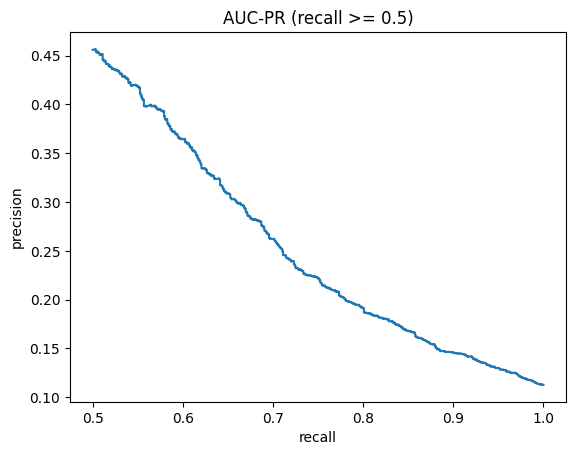

In [127]:
#your code here

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numerical)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
]
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
new_precision = precision[recall >= 0.5]
new_recall = recall[recall >= 0.5]
print("AUC-PR is {}".format(auc(new_recall, new_precision)))

plt.plot(new_recall, new_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('AUC-PR (recall >= 0.5)')


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ #your answer here

Омлет. P.S. рецепт смотрите в прошлой (вроде) дз, но в этот раз там было чисто очень много грибов, зелени и сыра